In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger

import pickle
import json
import re
from pathlib import Path

data_dir = Path(globals()['_dh'][0]).parent / 'data'
throughput_dir = data_dir / 'throughput' / 'iperf3'
figure_dir = data_dir / 'figures'
figure_dir.mkdir(exist_ok=True)

plt.style.use('seaborn-bright')
plt.set_cmap('plasma')

# list data files, sorted by date
data_files = sorted(throughput_dir.glob('*.json'), key=lambda x: x.name)
file = data_files[0]

<Figure size 432x288 with 0 Axes>

In [49]:
with Path('/home/ubuntu/skylark/data/throughput/iperf3/throughput_2022-01-04_22-12-49.json').open('rb') as f:
    data = json.load(f)
df = pd.DataFrame(data).set_index(['src', 'dst'])
df['throughput_gbps'] = df['throughput_mbps'] / 1024
df

congestion src_instance_class  \
src                      dst                                                 
gcp:europe-north1-a      gcp:europe-west1-b       cubic       n1-highcpu-8   
gcp:us-central1-a        aws:ap-northeast-1       cubic       n1-highcpu-8   
aws:eu-west-1            gcp:us-west1-a           cubic         i3en.large   
aws:sa-east-1            aws:us-east-1            cubic         i3en.large   
aws:us-west-1            aws:eu-central-1         cubic         i3en.large   
...                                                 ...                ...   
                         aws:sa-east-1            cubic         i3en.large   
gcp:southamerica-east1-a gcp:us-central1-a        cubic       n1-highcpu-8   
aws:ap-southeast-1       gcp:europe-west1-b       cubic         i3en.large   
gcp:asia-east2-a         gcp:europe-north1-a      cubic       n1-highcpu-8   
aws:us-east-1            aws:us-east-2            cubic         i3en.large   

                                             dst_instance_class  \
src                      dst                                      
gcp:europe-north1-a      gcp:europe-west1-b        n1-highcpu-8   
gcp:us-central1-a        aws:ap-northeast-1          i3en.large   
aws:eu-west-1            gcp:us-west1-a            n1-highcpu-8   
aws:sa-east-1            aws:us-east-1               i3en.large   
aws:us-west-1            aws:eu-central-1            i3en.large   
...                                                         ...   
                         aws:sa-east-1               i3en.large   
gcp:southamerica-east1-a gcp:us-central1-a         n1-highcpu-8   
aws:ap-southeast-1       gcp:europe-west1-b        n1-highcpu-8   
gcp:asia-east2-a         gcp:europe-north1-a       n1-highcpu-8   
aws:us-east-1            aws:us-east-2               i3en.large   

                                             src_network_tier  \
src                      dst                                    
gcp:europe-north1-a      gcp:europe-west1-b           PREMIUM   
gcp:us-central1-a        aws:ap-northeast-1           PREMIUM   
aws:eu-west-1            gcp:us-west1-a              STANDARD   
aws:sa-east-1            aws:us-east-1               STANDARD   
aws:us-west-1            aws:eu-central-1            STANDARD   
...                                                       ...   
                         aws:sa-east-1               STANDARD   
gcp:southamerica-east1-a gcp:us-central1-a            PREMIUM   
aws:ap-southeast-1       gcp:europe-west1-b          STANDARD   
gcp:asia-east2-a         gcp:europe-north1-a          PREMIUM   
aws:us-east-1            aws:us-east-2               STANDARD   

                                             dst_network_tier  data_sent  \
src                      dst                                               
gcp:europe-north1-a      gcp:europe-west1-b           PREMIUM   514.7754   
gcp:us-central1-a        aws:ap-northeast-1          STANDARD   198.8896   
aws:eu-west-1            gcp:us-west1-a               PREMIUM  1558.5410   
aws:sa-east-1            aws:us-east-1               STANDARD  1784.2393   
aws:us-west-1            aws:eu-central-1            STANDARD  1610.7168   
...                                                       ...        ...   
                         aws:sa-east-1               STANDARD  1530.9033   
gcp:southamerica-east1-a gcp:us-central1-a            PREMIUM   328.7432   
aws:ap-southeast-1       gcp:europe-west1-b           PREMIUM  1728.2480   
gcp:asia-east2-a         gcp:europe-north1-a          PREMIUM   798.3076   
aws:us-east-1            aws:us-east-2               STANDARD  1603.5186   

                                             runtime  throughput_mbps  cpu_tx  \
src                      dst                                                    
gcp:europe-north1-a      gcp:europe-west1-b     4.00        1079.9756    33.0   
gcp:us-central1-a        aws:ap-northeast-1     4.00         417.1340    12.0   

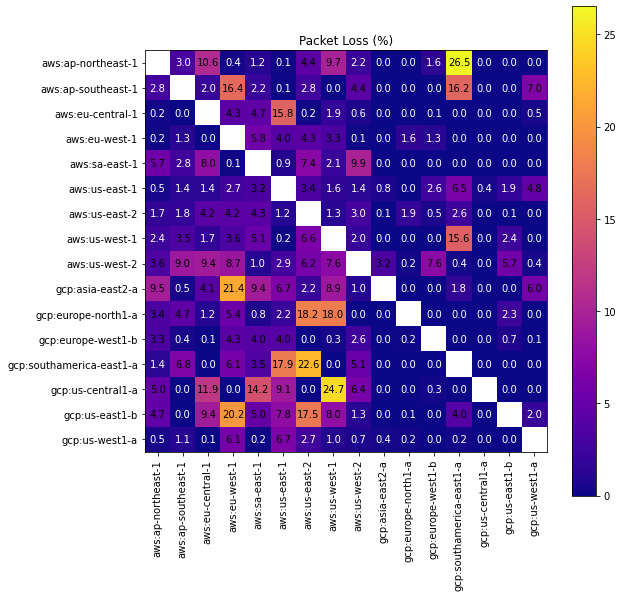

In [53]:
def plot_grid(df, title='Throughput (Gbps)', key='throughput_gbps'):
    regions = sorted(set(df.index.get_level_values('src')))
    data_grid = np.zeros((len(regions), len(regions)))

    for i, src in enumerate(regions):
        for j, dst in enumerate(regions):
            try:
                data_grid[i, j] = df.loc[src, dst][key]
            except KeyError:
                data_grid[i, j] = np.nan

    fig, ax = plt.subplots(1, 1, figsize=(9, 9))
    ax.imshow(data_grid)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(regions)))
    ax.set_yticks(np.arange(len(regions)))
    ax.set_xticklabels(regions)
    ax.set_yticklabels(regions)

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    # compute mean point of non nan values
    mean_point = np.nanmean(data_grid)
    for i, row in enumerate(data_grid):
        for j, col in enumerate(row):
            if not np.isnan(col):
                ax.text(j, i, round(col, 1), ha='center', va='center', color='white' if col < mean_point else 'black')

    fig.patch.set_facecolor('white')
    fig.subplots_adjust(hspace=0.6)
    ax.figure.colorbar(ax.images[0], ax=ax)
    return fig, ax

df_plot = df.copy()
fig, _ = plot_grid(df_plot, title='Throughput (Gbps)', key='throughput_gbps')
fig.savefig(figure_dir / 'udp_throughput_grid.pdf', bbox_inches='tight')
fig, _ = plot_grid(df_plot, title='Packet Loss (%)', key='loss_percent')
fig.savefig(figure_dir / 'udp_packet_loss_grid.pdf', bbox_inches='tight')